# 2021-12-08 • Cortical params for Hodgkin-Huxley

This is as {doc}`/notebooks/2021-12-06__local_HH_dV_shape`, but with params for HH model not for squid giant axon but a coritcal RS neuron. Most saliently, the firing threshold is way lower, closer to reality and to Izhikevich cortical RS.

## [Prelude]

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `lpxtf3` on `DUIP74576` on **Wed 08 Dec** 2021, at 20:00 (UTC+0000).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1119d931cf1ed9ff93d8a6c72ea030f1df584b9f
) (Tue 07 Dec 2021, 03:59).
Uncommited changes to 5 files.

## Params

Params from [Ch 2.2](https://neuronaldynamics.epfl.ch/online/Ch2.S2.html) of the epfl book.

In [194]:
c = 1 * (μF / cm**2)
E_K = -77 * mV
E_Na = 55 * mV
E_L = -65 * mV
g_K = 35 * (mS / cm**2)
g_Na = 40 * (mS / cm**2)
g_L = 0.3 * (mS / cm**2)

α_m = lambda V: 0.182 * (V/mV + 35) / (1 - np.exp((-35-V/mV)/9)) / ms
β_m = lambda V: -0.124 * (V/mV + 35) / (1 - np.exp((V/mV+35)/9)) / ms
m_inf = lambda V: α_m(V) / (α_m(V) + β_m(V))

α_n = lambda V: 0.02 * (V/mV - 25) / (1 - np.exp((25-V/mV)/9)) / ms
β_n = lambda V: -0.002 * (V/mV - 25) / (1 - np.exp((V/mV-25)/9)) / ms
n_inf = lambda V: α_n(V) / (α_n(V) + β_n(V))
τ_n = lambda V: 1 / (α_n(V) + β_n(V));

## Simplified Hodgkin-Huxley model

With $τ_m = 0$ and $n(t) \propto h(t)$, the 4D system is reduced to just 2D.   

In [195]:
h     = lambda n:        0.89 - 1.1 * n

I_K   = lambda V, n:     - g_K * n**4 * (V - E_K)
I_Na  = lambda V, n:     - g_Na * m_inf(V)**3 * h(n) * (V - E_Na)
I_L   = lambda V:        - g_L * (V - E_L)
I_tot = lambda V, n, I:  I + I_K(V,n) + I_Na(V,n) + I_L(V)
dV_dt = lambda V, n, I:  I_tot(V,n,I) / c

dn_dt = lambda V, n:     (n_inf(V) - n) / τ_n(V);

The equation for $\dot{n}$ is only used in the simulation at the end. The other sections all analyse $\dot{V}$ independently from $\dot{n}$.

## $dV/dt$

In [196]:
def horizontal_ylabel(ax, text, dx=-6, dy=-2, ha="right", x=0, y=1, bg_pad=0.4, **text_kwargs):
    """ dx and dy are in points, i.e. 1/72th of an inch. """
    offset = mpl.transforms.ScaledTranslation(dx/72, dy/72, ax.figure.dpi_scale_trans)
    bbox=dict(facecolor=ax.get_facecolor(), edgecolor='none', boxstyle=f'square,pad={bg_pad}')
    return ax.text(x, y, text, transform=ax.transAxes + offset,
                   ha=ha, va="top", bbox=bbox, **text_kwargs)

In [243]:
def make_V_dV_ax(V_min=-77*mV, V_max=-52*mV):
    fig, ax = plt.subplots()
    ax.axhline(y=0, color='k')
    ax.set_xlabel("$V$ (mV)")
    horizontal_ylabel(ax, "$\dot{V}$ (mV/mS)")
    V = np.linspace(V_min, V_max, num=1000)
    return ax, V

In [244]:
f = partial(dV_dt, n=0.25, I=0);

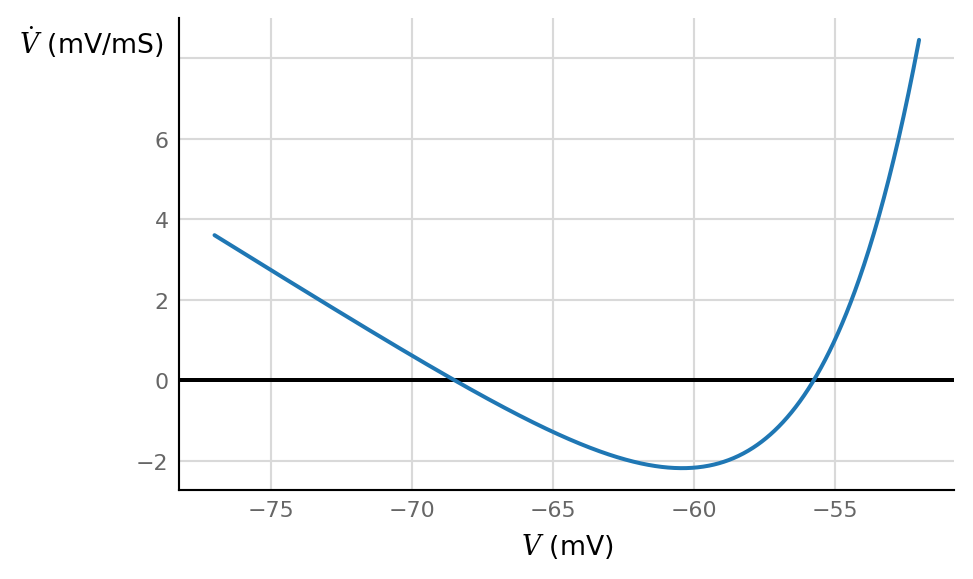

In [245]:
ax, V = make_V_dV_ax()
ax.plot(V / mV, f(V) / (mV / ms));

### Izhikevich's $dV/dt$

In [246]:
from scipy.optimize import newton

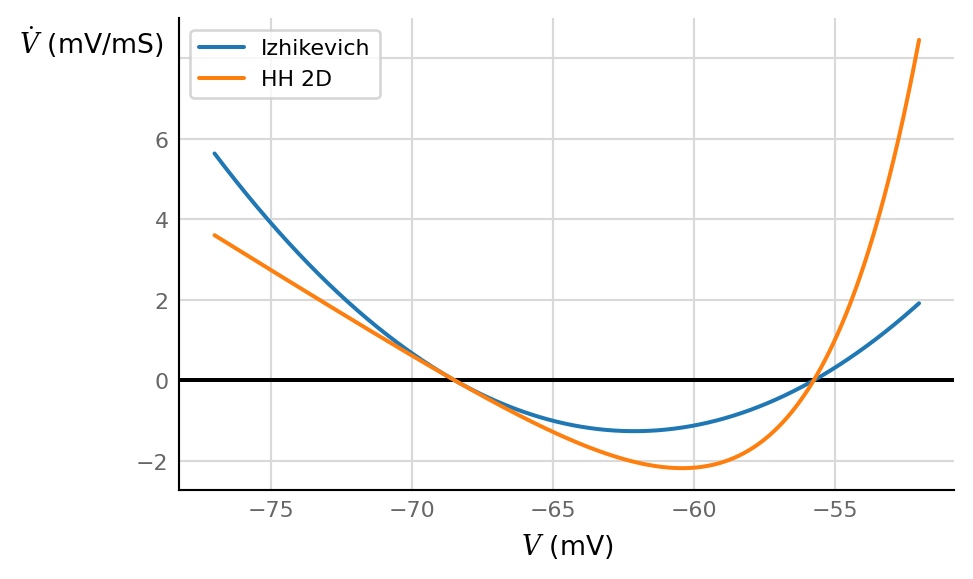

In [257]:
C = 22.5 * pF       # 100 pF
k = 0.7 * (nS/mV)

V_r, V_t = newton(f, [-70*mV, -55*mV])

dV_dt_Izh = lambda V: (k * (V - V_r) * (V - V_t)) / C

ax, V = make_V_dV_ax()
# ax, V = make_V_dV_ax(V_r-0.1*mV, V_r+0.1*mV)
ax.plot(V / mV, dV_dt_Izh(V) / (mV / ms), label="Izhikevich")
ax.plot(V / mV, f(V) / (mV / ms), label="HH 2D")
# ax.set_xlim(-100, 20)
# ax.set_ylim(-1.7, 4.9)
ax.set_xlim()
# label_lines(ax.lines, xvals=[-88, -18], outline_width=7);
ax.legend();

The parabola's zeros ($V_r$ and $V_t$) were chosen to match those of the 2D Hodgkin-Huxley model.  
The capacitance $C$ was chosen so that the slopes of the two models approximately match at the resting potential.

## Slow current gating variable $n$

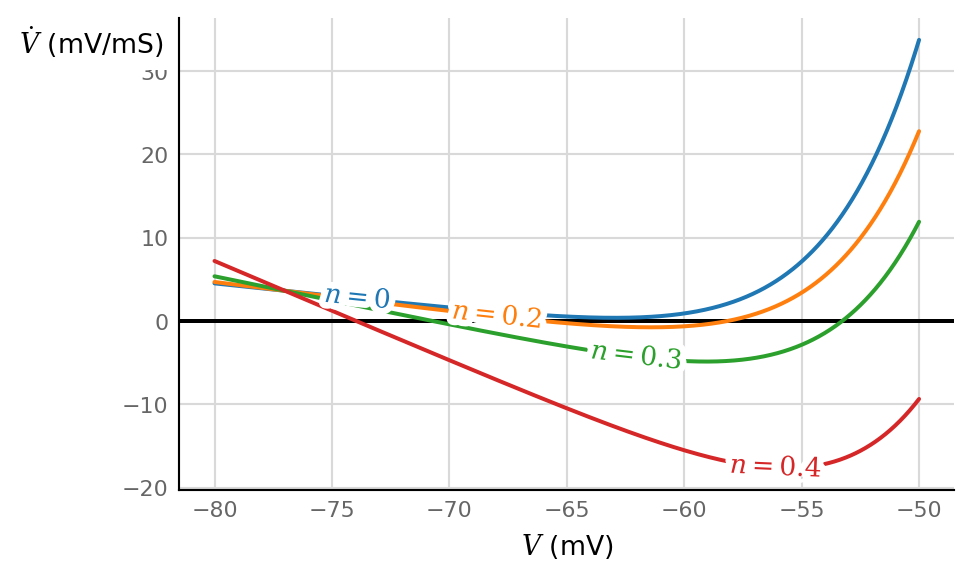

In [202]:
ax, V = make_V_dV_ax()
for n in [0, 0.2, 0.3, 0.4]:
    ax.plot(V / mV, dV_dt(V, n, I=0) / (mV / ms), label=f"$n = {n}$")

labels = label_lines(ax.lines);  # labels after lims, so rotations are correct (issue 36)

In [203]:
n = n_inf(V_r)

0.00023997233576810773

Neuron spikes without input current, that ain't right.

In [204]:
I_Na(V_r, n=0.3) * (nA/mm**2)

5.505099801252533e-07

In [205]:
I_K(V_r, n=0.3) * (nA/mm**2)

-1.775847400062642e-05

In [206]:
I_L(V_r) * (nA/mm**2)

1.7207964020501135e-05

## Simulation

Time

In [207]:
duration = 2 * second
duration = 500 * ms
Δt = 0.01 * ms

N = round(duration / Δt)
t = np.linspace(0, duration / ms, N, endpoint=False);

Input

In [212]:
from scipy.signal.windows import gaussian

np.random.seed(1)

I = np.random.randn(N) * 400 * nA/mm**2
σ = 6 * ms
M = round(2 * 4 * σ / Δt)
I = np.convolve(I, gaussian(M, std=σ / Δt) / M, "same");  # local weighted average, to smooth

# I = np.ones(N) * 0 * nA/mm**2;

ODE integration

In [213]:
V = np.ones(N) * V_r
n = np.ones(N) * 0.3

for i in range(N - 1):
    V[i+1] = V[i] + dV_dt(V[i], n[i], I[i]) * Δt
    n[i+1] = n[i] + dn_dt(V[i], n[i]) * Δt

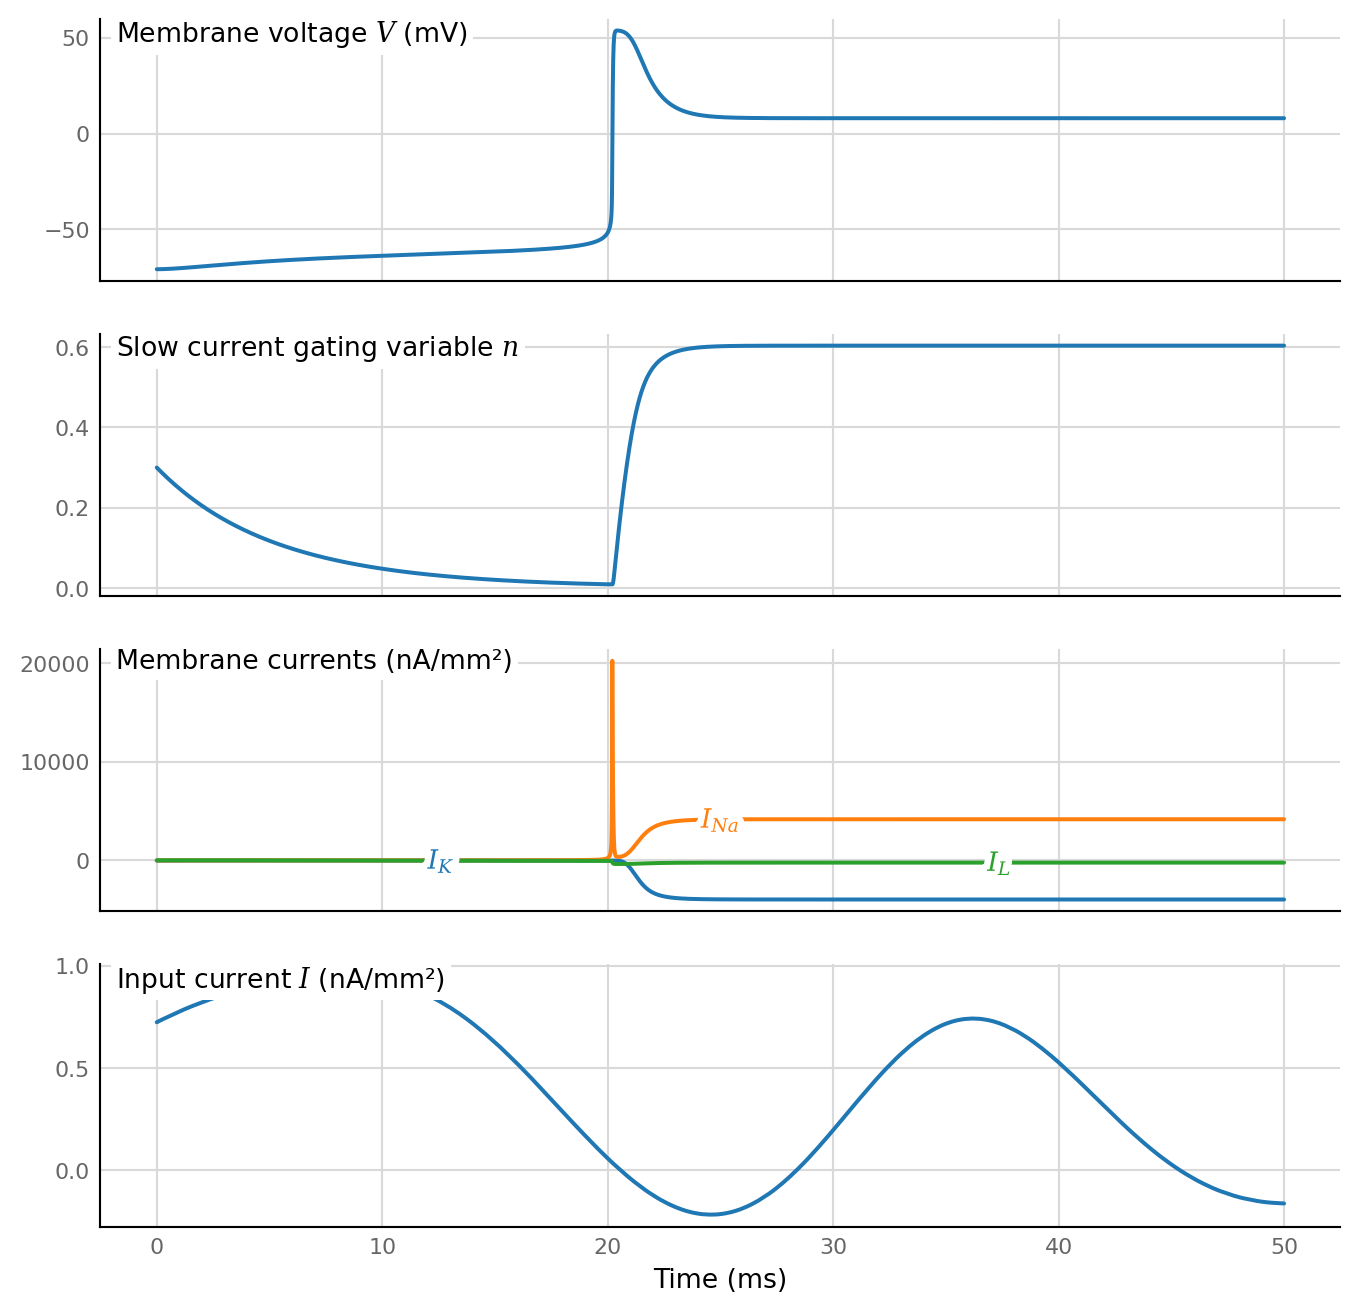

In [214]:
nrows = 4
fig, axs = plt.subplots(nrows, **v.figsize(width=800, aspect=1), sharex=True)

ylabel_inside = partial(horizontal_ylabel, ha="left", dx=6, dy=0, bg_pad=0.2)

axs[0].plot(t, V / mV)
ylabel_inside(axs[0], "Membrane voltage $V$ (mV)")

axs[1].plot(t, n)
# axs[1].set_ylim(bottom=0)
ylabel_inside(axs[1], "Slow current gating variable $n$")

axs[2].plot(t, I_K(V, n) / (nA/mm**2), label="$I_{K}$")
axs[2].plot(t, I_Na(V, n) / (nA/mm**2), label="$I_{Na}$")
axs[2].plot(t, I_L(V) / (nA/mm**2), label="$I_{L}$")
# axs[2].set_ylim(-32, 32)
ylabel_inside(axs[2], "Membrane currents (nA/mm²)")
label_lines(axs[2].lines, align=False)

axs[3].plot(t, I / (nA/mm**2))
ylabel_inside(axs[3], "Input current $I$ (nA/mm²)")
axs[3].set_xlabel("Time (ms)");

## ..

Eh. I'd have to use full HH equations, not 2D approx.  
Params not from epfl book guess, but eg from https://brian2.readthedocs.io/en/stable/examples/COBAHH.html . (that's.. hippocampal pyramidal? (Traub ref).

I just want to know how 'wrong' Izhikevich is compared to reality.  
Let's reproduce dV curve from Badel 2008, fig 2 B&C.  
(fig 2 is for cortical neuron, fig 1 for something else).

See new notebook.

## [Reproducibility]

In [25]:
v.print_reproducibility_info(verbose=True) 

This cell was last run by `lpxtf3` on `DUIP74576`<br>on **Tue 07 Dec** 2021, at 02:33 (UTC+0000).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/07777f4c6e003722f8d60533c3d2f50d9c50d3b0
) (Mon 06 Dec 2021, 20:02).

Uncommited changes to:
```
 M notebooks/2021-12-06__local_HH_dV_shape.ipynb
?? notebooks/2021-11-18__constant_input_spikes.ipynb
?? notebooks/2021-11-18__prototype_new_sim.ipynb
```

Platform:

Windows-10
CPython 3.9.6 (C:\miniforge3\python.exe)
Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.21.1
matplotlib           3.4.2
numba                0.53.1
joblib               1.0.1
seaborn              0.11.1
scipy                1.7.0
preload              2.2
nptyping             1.4.2


Full conda list:

```
# packages in environment at C:\miniforge3:
#
# Name                    Version                   Build  Channel
argon2-cffi               20.1.0           py39hb82d6ee_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
black                     21.9b0             pyhd8ed1ab_1    conda-forge
bleach                    3.3.1              pyhd8ed1ab_0    conda-forge
brian2                    2.5.0.1          py39h2e07f2f_0    conda-forge
brotlipy                  0.7.0           py39hb82d6ee_1001    conda-forge
ca-certificates           2021.10.8            h5b45459_0    conda-forge
certifi                   2021.10.8        py39hcbf5309_1    conda-forge
cffi                      1.14.6           py39h0878f49_0    conda-forge
chardet                   4.0.0            py39hcbf5309_1    conda-forge
charset-normalizer        2.0.0              pyhd8ed1ab_0    conda-forge
click                     7.1.2                    pypi_0    pypi
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
colorful                  0.5.4                    pypi_0    pypi
conda                     4.11.0           py39hcbf5309_0    conda-forge
conda-package-handling    1.7.3            py39hb3671d1_0    conda-forge
cryptography              3.4.7            py39hd8d06c1_0    conda-forge
cycler                    0.10.0                   pypi_0    pypi
cython                    0.29.24          py39h415ef7b_1    conda-forge
dataclasses               0.8                pyhc8e2a94_3    conda-forge
debugpy                   1.4.1            py39h415ef7b_0    conda-forge
decorator                 5.0.9              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
gsl                       2.7                  hdfb1a43_0    conda-forge
icu                       68.2                 h0e60522_0    conda-forge
idna                      3.1                pyhd3deb0d_0    conda-forge
importlib-metadata        4.6.1            py39hcbf5309_0    conda-forge
intel-openmp              2021.4.0          h57928b3_3556    conda-forge
ipykernel                 6.0.3            py39h832f523_0    conda-forge
ipython                   7.25.0           py39h832f523_1    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
ipywidgets                7.6.5              pyhd8ed1ab_0    conda-forge
jedi                      0.18.0           py39hcbf5309_2    conda-forge
jinja2                    3.0.1              pyhd8ed1ab_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
jsonschema                3.2.0              pyhd8ed1ab_3    conda-forge
jupyter_client            6.1.12             pyhd8ed1ab_0    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1              pyhd8ed1ab_2    conda-forge
jupyter_core              4.7.1            py39hcbf5309_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py39hcbf5309_1002    conda-forge
jupyter_latex_envs        1.4.6           pyhd8ed1ab_1002    conda-forge
jupyter_nbextensions_configurator 0.4.1            py39hcbf5309_2    conda-forge
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
jupyterlab_widgets        1.0.2              pyhd8ed1ab_0    conda-forge
kiwisolver                1.3.1                    pypi_0    pypi
libblas                   3.9.0              12_win64_mkl    conda-forge
libcblas                  3.9.0              12_win64_mkl    conda-forge
libclang                  11.1.0          default_h5c34c98_1    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
liblapack                 3.9.0              12_win64_mkl    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libxml2                   2.9.12               hf5bbc77_0    conda-forge
libxslt                   1.1.33               h65864e5_2    conda-forge
libzlib                   1.2.11            h8ffe710_1013    conda-forge
llvmlite                  0.36.0                   pypi_0    pypi
lxml                      4.6.3            py39h4fd7cdf_0    conda-forge
m2w64-gcc-libgfortran     5.3.0                         6    conda-forge
m2w64-gcc-libs            5.3.0                         7    conda-forge
m2w64-gcc-libs-core       5.3.0                         7    conda-forge
m2w64-gmp                 6.1.0                         2    conda-forge
m2w64-libwinpthread-git   5.0.0.4634.697f757               2    conda-forge
markupsafe                2.0.1            py39hb82d6ee_0    conda-forge
matplotlib                3.4.2                    pypi_0    pypi
matplotlib-inline         0.1.2              pyhd8ed1ab_2    conda-forge
matplotlib-label-lines    0.4.3                    pypi_0    pypi
menuinst                  1.4.17           py39hcbf5309_1    conda-forge
miniforge_console_shortcut 2.0                  h57928b3_0    conda-forge
mistune                   0.8.4           py39hb82d6ee_1004    conda-forge
mkl                       2021.4.0           h0e2418a_729    conda-forge
more-itertools            8.12.0                   pypi_0    pypi
mpmath                    1.2.1              pyhd8ed1ab_0    conda-forge
msys2-conda-epoch         20160418                      1    conda-forge
mypy_extensions           0.4.3            py39hcbf5309_4    conda-forge
nbclient                  0.5.3              pyhd8ed1ab_0    conda-forge
nbconvert                 6.1.0            py39hcbf5309_0    conda-forge
nbformat                  5.1.3              pyhd8ed1ab_0    conda-forge
nest-asyncio              1.5.1              pyhd8ed1ab_0    conda-forge
notebook                  6.4.0              pyha770c72_0    conda-forge
nptyping                  1.4.2                    pypi_0    pypi
numba                     0.53.1                   pypi_0    pypi
numpy                     1.21.1                   pypi_0    pypi
openssl                   1.1.1l               h8ffe710_0    conda-forge
packaging                 21.0               pyhd8ed1ab_0    conda-forge
pandas                    1.3.1                    pypi_0    pypi
pandoc                    2.14.1               h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.8.2              pyhd8ed1ab_0    conda-forge
pathspec                  0.9.0              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.3.1                    pypi_0    pypi
pip                       21.2.1             pyhd8ed1ab_0    conda-forge
platformdirs              2.3.0              pyhd8ed1ab_0    conda-forge
preload                   2.2                      pypi_0    pypi
prettyprinter             0.18.0                   pypi_0    pypi
prometheus_client         0.11.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.19             pyha770c72_0    conda-forge
py-cpuinfo                8.0.0              pyhd8ed1ab_0    conda-forge
pycosat                   0.6.3           py39hb82d6ee_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.9.0              pyhd8ed1ab_0    conda-forge
pympler                   0.9                      pypi_0    pypi
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py39hcbf5309_7    conda-forge
pyqt-impl                 5.12.3           py39h415ef7b_7    conda-forge
pyqt5-sip                 4.19.18          py39h415ef7b_7    conda-forge
pyqtchart                 5.12             py39h415ef7b_7    conda-forge
pyqtwebengine             5.12.1           py39h415ef7b_7    conda-forge
pyrsistent                0.17.3           py39hb82d6ee_2    conda-forge
pysocks                   1.7.1            py39hcbf5309_3    conda-forge
python                    3.9.6           h7840368_1_cpython    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python_abi                3.9                      2_cp39    conda-forge
pytz                      2021.1                   pypi_0    pypi
pywin32                   300              py39hb82d6ee_0    conda-forge
pywinpty                  1.1.3            py39h99910a6_0    conda-forge
pyyaml                    6.0              py39hb82d6ee_0    conda-forge
pyzmq                     22.1.0           py39he46f08e_0    conda-forge
qt                        5.12.9               h5909a2a_4    conda-forge
regex                     2021.10.23       py39hb82d6ee_1    conda-forge
requests                  2.26.0             pyhd8ed1ab_0    conda-forge
ruamel_yaml               0.15.80         py39hb82d6ee_1004    conda-forge
scipy                     1.7.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi
send2trash                1.7.1              pyhd8ed1ab_0    conda-forge
setuptools                49.6.0           py39hcbf5309_3    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
sqlite                    3.36.0               h8ffe710_0    conda-forge
sympy                     1.9              py39hcbf5309_1    conda-forge
tbb                       2021.4.0             h2d74725_1    conda-forge
terminado                 0.10.1           py39hcbf5309_0    conda-forge
testpath                  0.5.0              pyhd8ed1ab_0    conda-forge
tomli                     1.2.2              pyhd8ed1ab_0    conda-forge
tornado                   6.1              py39hb82d6ee_1    conda-forge
tqdm                      4.61.2             pyhd8ed1ab_1    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
typed-ast                 1.4.3            py39hb82d6ee_1    conda-forge
typing_extensions         3.10.0.2           pyha770c72_0    conda-forge
typish                    1.9.2                    pypi_0    pypi
tzdata                    2021a                he74cb21_1    conda-forge
ucrt                      10.0.20348.0         h57928b3_0    conda-forge
urllib3                   1.26.6             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_5    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.29.30037          h902a5da_5    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
widgetsnbextension        3.5.2            py39hcbf5309_1    conda-forge
win_inet_pton             1.1.0            py39hcbf5309_2    conda-forge
wincertstore              0.2             py39hcbf5309_1006    conda-forge
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
yaml                      0.2.5                he774522_0    conda-forge
zeromq                    4.3.4                h0e60522_0    conda-forge
zipp                      3.5.0              pyhd8ed1ab_0    conda-forge
zlib                      1.2.11            h8ffe710_1013    conda-forge
```